In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
%matplotlib inline
import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)


67 sessions!
67 sessions!


<module 'switch_analysis_one_session' from '/mnt/home/szheng/projects/nmf_analysis/scripts/switch_analysis_one_session.py'>

In [2]:
# data_dir_full = '/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/'
data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][0] #0
print(data_dir_full)
# load data
mat_to_return=prep.load_stuff(data_dir_full,sessionPulses='*SessionPulses.Events.mat')
# sessionPulses=mat_to_return['sessionPulses']
# filtered = mat_to_return['filtered']
behavior=mat_to_return['behavior']
# ripples = mat_to_return['ripples']
cell_metrics = mat_to_return['cell_metrics']

prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
spk_beh_df=prep_res['spk_beh_df']
_,spk_beh_df = dpp.group_into_trialtype(spk_beh_df)
spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,nbins=100)
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df']
beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']


/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913


/mnt/home/szheng/ceph/envs/ssm/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


load *SessionPulses.Events.mat failed


In [3]:
reload(pa)
cell_cols = cell_cols_d['pyr']
fr_map_d,_,_ = pf.ratemap_from_spk_beh_df_alltrialtype(spk_beh_df,cell_cols_d['pyr'],speed_thresh=1,nbins=100,smth_in_bin=5,speed_key='v')
fr_map_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols,trialtype_key='trial_type',speed_thresh=1.,order=['smooth','divide'],speed_key='v')
fr_map_trial_d = {k:val[0] for k,val in fr_map_dict.items()}
fr_map_trial_df_d=pd.concat({k:pf.fr_map_trial_to_df(fr_map_trial_d[k],cell_cols) for k in fr_map_dict.keys()},axis=0)


cant format into a dataframe
cant format into a dataframe


In [4]:
pf_res =pf.field_detection_both_avg_trial_wrapper(data_dir_full, dosave=True,force_reload=False,nbins = 100, 
                                        save_fn = 'place_field_avg_and_trial_vthresh.p', 
                                        shuffle_fn='fr_map_null_trialtype_vthresh.p',
                                        smth_in_bin=2.5, speed_thresh=1.,speed_key='v',load_only=True
                                        )

switch_res = saos.switch_analysis_one_session(data_dir_full,place_field_res=None,force_reload=False,nrepeats=1000,
                                              save_fn=saos.SAVE_FN(saos.FR_KEY),load_only=True)

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---


In [5]:
task_ind,tt_ind = 0,0
pf_param = pf_res['avg']['params'][task_ind,tt_ind]
changes_df = switch_res['avg']['changes_df'].loc[task_ind,tt_ind,0.3,'switch_magnitude',0.4].dropna(axis=1)
fr_map_trial_df = fr_map_trial_df_d.loc[task_ind,tt_ind].dropna(axis=1)

no_sw_fields = changes_df.loc[(changes_df.abs().sum(axis=1) ==0)].index
with_sw_fields = changes_df.loc[(changes_df.abs().sum(axis=1) !=0)].index

/tmp/ipykernel_1099992/3810986821.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  changes_df = switch_res['avg']['changes_df'].loc[task_ind,tt_ind,0.3,'switch_magnitude',0.4].dropna(axis=1)


In [6]:
from scipy.ndimage import gaussian_filter1d
import sklearn
from sklearn.decomposition import PCA,SparsePCA,MiniBatchSparsePCA

import animate_helper as ah
reload(ah)

<module 'animate_helper' from '/mnt/home/szheng/projects/util_code/animate_helper.py'>

In [7]:
reload(pf)

<module 'place_field_analysis' from '/mnt/home/szheng/projects/util_code/place_field_analysis.py'>

In [8]:
# no speed thresh, get rate map
fr_map_d_run,_,_ = pf.ratemap_from_spk_beh_df_alltrialtype(spk_beh_df,cell_cols_d['pyr'],speed_thresh=1,nbins=100,smth_in_bin=0,speed_key='speed')
fr_map_d_lowsp,_,_ = pf.ratemap_from_spk_beh_df_alltrialtype(spk_beh_df.query('speed<1'),cell_cols_d['pyr'],speed_thresh=0,nbins=100,smth_in_bin=0,speed_key='speed')




In [9]:
import pca_analysis as pcaa
reload(pcaa)

<module 'pca_analysis' from '/mnt/home/szheng/projects/nmf_analysis/pca_analysis.py'>

In [10]:
import surrogate_data as sd

In [11]:
fr_map_run = fr_map_d_run[task_ind,tt_ind]
fr_map_lowsp = fr_map_d_lowsp[task_ind,tt_ind]
spk_beh_onetrial = spk_beh_df.query('trial==33')

lin_binned = spk_beh_onetrial['lin_binned']
speed = spk_beh_onetrial['speed']

fr_exp = sd.get_expected_fr_from_pos(lin_binned,fr_map_run,v=speed,fr_map_lowsp=fr_map_lowsp,v_thresh=1)

In [12]:
# X = spk_beh_onetrial[cell_cols_d['pyr']]
X = fr_exp.T

X_prep = pcaa.preprocess_pca(X,do_sqrt=True,do_smooth=True,smooth_kws={'sigma':3},do_center=True,do_normalize=True,normalize_kws={'type':'max','percent_max':0.5})

reload(pcaa)
X_reduced,W,pca,n_compo = pcaa.do_pca(X_prep,var_thresh=0.95)


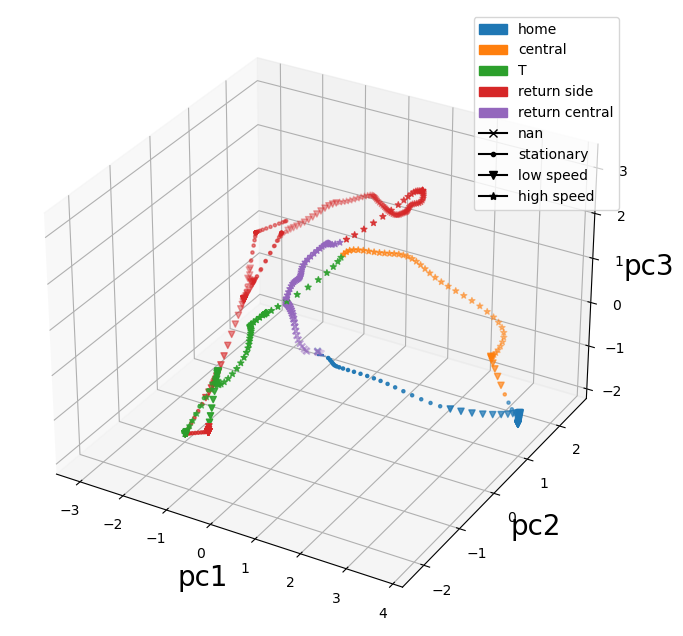

In [17]:
# static plot
%matplotlib inline
reload(ph)
color_in_time,marker_in_time,legend_l,legend_l_color,legend_l_marker = ph.prep_hue_scatter(spk_beh_onetrial,speed_key='v')

comp_l = [0,1,2]
X_reduced_sub = X_reduced[comp_l]

fig,ax=ph.plot_pca3d(X_reduced_sub.values,color=color_in_time,marker=marker_in_time)
ax.legend(handles=legend_l)
fig

<IPython.core.display.Javascript object>


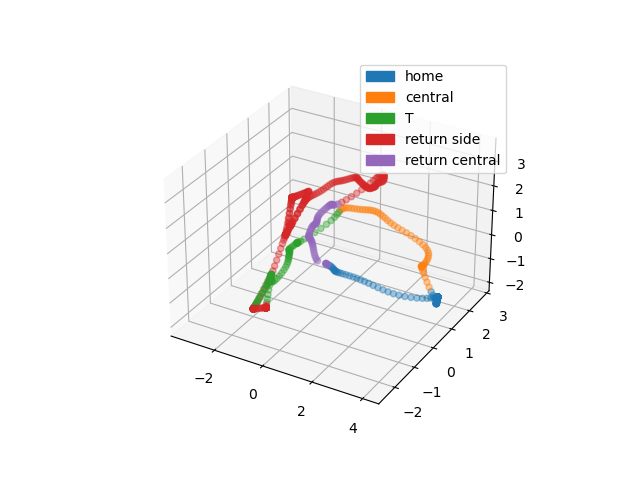

<IPython.core.display.Javascript object>


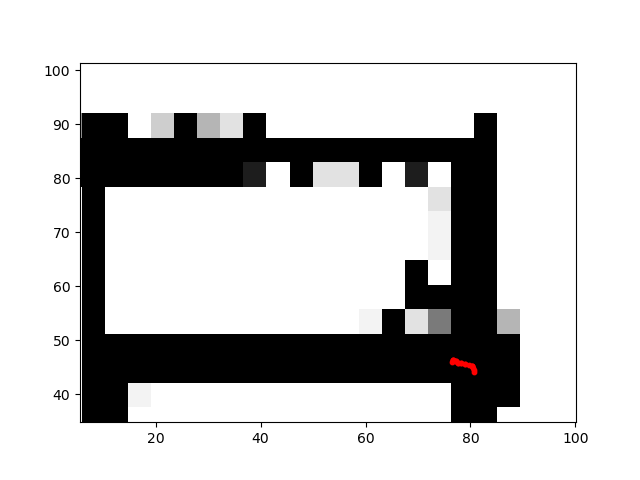

In [21]:
# animate
%matplotlib notebook
reload(ph)
reload(ah)
animate_kws = {'interval':10}
fig,ax,ani=ah.animate_3d_scatter(X_reduced_sub.values.T,color_l=color_in_time,legend_handles=legend_l_color,animate_kws=animate_kws)

pos_data = spk_beh_onetrial['lin'].reset_index().values.T
# fig,ax,ani_line = ah.animate_line(pos_data,legend_handles=None,color_l=None,fig=None,ax=None,ax_kws={},animate_kws=animate_kws,dosave=False)
fig,ax,ani_maze=ah.animate_movement_in_maze(spk_beh_onetrial[['x','y']].T.values,spk_beh_df['x'],spk_beh_df['y'])



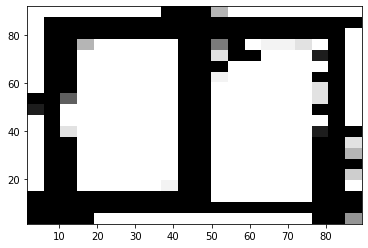

In [167]:
%matplotlib inline
val,bin1,bin2,im=plt.hist2d(spk_beh_df['y'],spk_beh_df['x'],cmap='Greys',bins=(20,20),vmax=10)

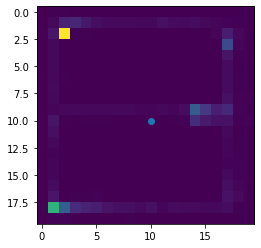

In [172]:
plt.imshow(val)
plt.scatter([10],[10])

<IPython.core.display.Javascript object>


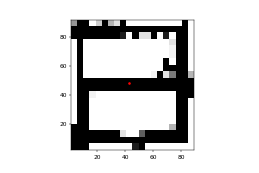

In [209]:
reload(ah)
fig,ax=ah.plot_background_maze(x_all,y_all,hist2d_kws={},fig=None,ax=None)

In [210]:
ax.scatter([43],[48],c='red',s=10)

<IPython.core.display.Javascript object>


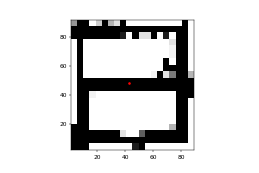

In [211]:
fig

In [228]:
particles

array([([0.15796455, 0.17890439], [-0.17720395, -0.32767101], [ 1.68348993,  0.15649553], 0.5),
       ([0.02318449, 0.34682951], [ 0.37824617,  0.28237211], [-0.06009703, -1.35035736], 0.5),
       ([0.59549752, 0.89041258], [ 0.39486202,  0.21192037], [-1.8506314 , -0.96774739], 0.5),
       ([0.79283304, 0.00368194], [-0.08259698,  0.83606132], [-1.00843451, -0.14011072], 0.5),
       ([0.48837885, 0.41366493], [ 0.47516463, -0.11124959], [ 0.54630633, -0.35636252], 0.5),
       ([0.17670345, 0.79582518], [-0.10523267,  0.37421654], [-1.61542409,  1.54703332], 0.5),
       ([0.25443784, 0.92464248], [-0.11680858,  0.52192707], [-1.4069661 , -0.53496312], 0.5),
       ([0.28082135, 0.80746466], [-0.3858511 , -0.06581445], [ 0.38876513,  0.69476894], 0.5),
       ([0.9192483 , 0.57004872], [ 0.16828519,  0.03739641], [ 1.65983028,  0.56124468], 0.5),
       ([0.71752325, 0.50402131], [-0.21342617,  0.11159719], [ 1.21404279, -1.62382208], 0.5),
       ([0.45135634, 0.08518662], [-0.31

/tmp/ipykernel_590815/553664763.py:9: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  particles=np.zeros(n,dtype=[("position", float , 2),


<IPython.core.display.Javascript object>


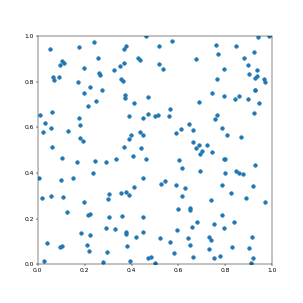

In [233]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

dt = 0.005
n=200
L = 1
particles=np.zeros(n,dtype=[("position", float , 2),
                           ("velocity", float ,2),
                           ("force", float ,2),
                           ("size", float , 1)])

particles["position"]=np.random.uniform(0,L,(n,2));
particles["velocity"]=np.zeros((n,2));
particles["size"]=0.5*np.ones(n);

fig = plt.figure(figsize=(7,7))
ax = plt.axes(xlim=(0,L),ylim=(0,L))
# scatter=ax.scatter(particles["position"][:,0], particles["position"][:,1])
scatter=ax.scatter(particles["position"][0,0], particles["position"][0,1])

def update(frame_number):
   particles["force"]=np.random.uniform(-2,2.,(n,2));
   particles["velocity"] = particles["velocity"] + particles["force"]*dt
   particles["position"] = particles["position"] + particles["velocity"]*dt

   particles["position"] = particles["position"]%L
   scatter.set_offsets(particles["position"][:frame_number])
   return scatter,

anim = FuncAnimation(fig, update, interval=10)
plt.show()

<IPython.core.display.Javascript object>


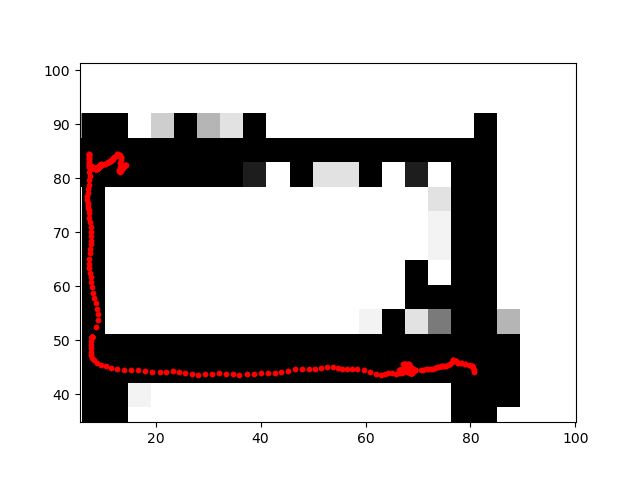

In [19]:
%matplotlib notebook
reload(ah)

fig,ax,ani=ah.animate_movement_in_maze(spk_beh_onetrial[['x','y']].T.values,spk_beh_df['x'],spk_beh_df['y'])

<IPython.core.display.Javascript object>


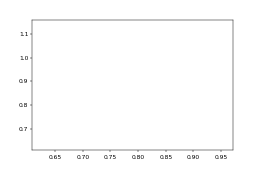

In [253]:
%matplotlib notebook
# data=spk_beh_onetrial[['x','y']].T.values
data = particles["position"]

fig,ax=plt.subplots()
ax_kws_ = {}
ax_kws_['xlim'] = (data[0].min() - np.abs(data[0].min()) * 0.2, data[0].max() + np.abs(data[0].max())*0.2)
ax_kws_['ylim'] = (data[1].min() - np.abs(data[1].min()) * 0.2, data[1].max() + np.abs(data[1].max())*0.2)
# ax_kws_.update(ax_kws)
ax.set(**ax_kws_)

# fig,ax=plot_background_maze(x_all,y_all,hist2d_kws=hist2d_kws,fig=fig,ax=ax)

# scat = ax.scatter(data[0,0],data[1,0],alpha=1,c='red',s=10)
scat = ax.scatter(data[0,0],data[1,0])

def init():
    ax.set(ax_kws_)
    return scat,

def animate(frame):
    scat.set_offsets(data[:frame])
    return scat,

kws = dict(blit=False,frames=data.shape[1],interval=10)
# kws.update(animate_kws)
ani = FuncAnimation(fig,animate,**kws)
plt.show()

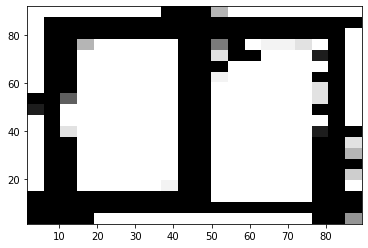

In [155]:
%matplotlib inline
x_all,y_all = spk_beh_df['x'],spk_beh_df['y']
fig,ax=ah.plot_background_maze(x_all,y_all,hist2d_kws={},fig=fig,ax=ax)
data = spk_beh_onetrial[['y','x']].T.values
scat = ax.scatter(data[0,0],data[1,0],alpha=1,c='white',s=5)

In [156]:
ax.plot([10,50],[40,60])

In [148]:
data[0,0]

80.71839654399417

In [88]:
X_reduced.shape

(821, 63)

In [90]:
W.shape

(63, 422)

<AxesSubplot:xlabel='lin_binned'>

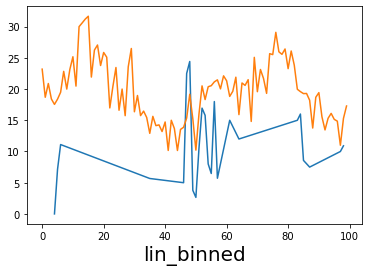

In [97]:
%matplotlib inline
fr_map_d_lowsp[task_ind,tt_ind].loc[27].plot()
fr_map_d_run[task_ind,tt_ind].loc[27].plot()

In [53]:
trial_index_dict = dpp.trial_index_to_index_within_trialtype(spk_beh_df)

In [35]:
trial_index_dict

{(0,
  0.0): 0
 1.0      0
 3.0      1
 6.0      2
 8.0      3
 10.0     4
 12.0     5
 14.0     6
 16.0     7
 18.0     8
 20.0     9
 23.0    10
 25.0    11
 27.0    12
 29.0    13
 31.0    14
 33.0    15
 35.0    16
 37.0    17
 39.0    18
 41.0    19
 43.0    20
 45.0    21
 47.0    22
 49.0    23
 51.0    24
 53.0    25
 55.0    26
 57.0    27
 59.0    28
 61.0    29
 63.0    30
 65.0    31
 68.0    32
 Name: index, dtype: int64,
 (0,
  1.0): 0
 0.0      0
 2.0      1
 4.0      2
 5.0      3
 7.0      4
 9.0      5
 11.0     6
 13.0     7
 15.0     8
 17.0     9
 19.0    10
 21.0    11
 22.0    12
 24.0    13
 26.0    14
 28.0    15
 30.0    16
 32.0    17
 34.0    18
 36.0    19
 38.0    20
 40.0    21
 42.0    22
 44.0    23
 46.0    24
 48.0    25
 50.0    26
 52.0    27
 54.0    28
 56.0    29
 58.0    30
 60.0    31
 62.0    32
 64.0    33
 66.0    34
 67.0    35
 69.0    36
 Name: index, dtype: int64}

In [8]:
fr_map_run = fr_map_d_run[task_ind,tt_ind]
fr_map_lowsp = fr_map_d_lowsp[task_ind,tt_ind]
spk_beh_onetrial = spk_beh_df.query('trial==33')

lin_binned = spk_beh_onetrial['lin_binned']

In [101]:
uid=27

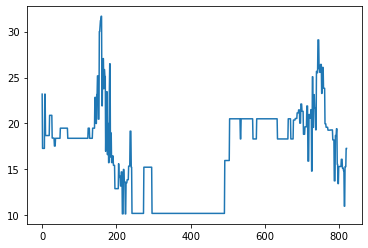

In [102]:
plt.plot(fr_map_run.loc[:,lin_binned].loc[uid].values)

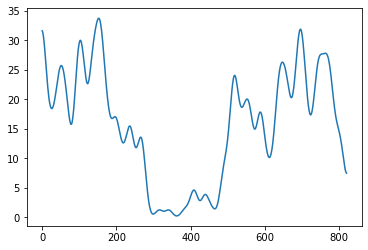

In [111]:
plt.plot(gaussian_filter1d(spk_beh_onetrial[uid].astype(float),10) / 0.033)

In [9]:
def get_expected_fr_from_pos(lin_binned,fr_map_run,v=None,fr_map_lowsp=None,v_thresh=1):
    '''
    lin_binned: position bin in time
    fr_map_run,fr_map_lowsp: ratemaps, nneurons x nposbins
    v: speed in time
    v_thresh: thresh for run vs lowsp
    '''

    fr_exp = fr_map_run.loc[:,lin_binned]
    if v is not None:
        low_sp_ma = v < v_thresh
#         import pdb
#         pdb.set_trace()
        fr_exp.loc[:,low_sp_ma.values] = fr_map_lowsp.loc[:,lin_binned.loc[low_sp_ma]]
    return fr_exp
    
    

In [10]:
speed = spk_beh_onetrial['speed']
fr_exp = get_expected_fr_from_pos(lin_binned,fr_map_run,v=speed,fr_map_lowsp=fr_map_lowsp,v_thresh=1)

<AxesSubplot:xlabel='lin_binned'>

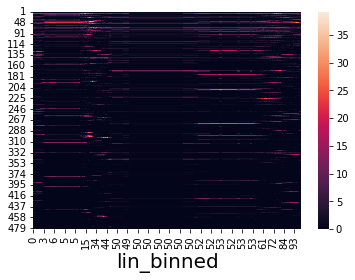

In [12]:
%matplotlib inline
sns.heatmap(fr_exp)